### TASK: Create Encder-Decoder LSTM model to convert English sentences to Hindi sentences.  
We are going to use word level embedding

In [2]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

### Kaggle Configuration (Run Once)

In [3]:
# ! pip install kaggle

# from google.colab import files

# uploaded = files.upload()

# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))
  
# # Then move kaggle.json into the folder where the API expects to find it.
# !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download aiswaryaramachandran/hindienglish-corpora/download?datasetVersionNumber=1

# !unzip hindienglish-corpora


## Preparing Data

### 1 .  Import Libraries

In [4]:

#%tensorflow_version 2.x

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing , utils
import pandas as pd
import math



### 2 . Read Data


In [5]:

num_words= 5000 ## number of tokens
data = pd.read_csv('Hindi_English_Truncated_Corpus.csv')
data.tail()
data=data[:10000]
max_sentence_length= 15
data['english_sentence']=data['english_sentence'].apply(lambda x: str(x))
data['english_sentence']=data['english_sentence'].apply(lambda x:" ".join(x.split()[:max_sentence_length]) )
data['hindi_sentence']=data['hindi_sentence'].apply(lambda x:" ".join(x.split()[:max_sentence_length]) )



df = pd.DataFrame({'eng': data['english_sentence'], 'hindi': data['hindi_sentence']})
lines= df
half_dataSize= math.floor(len(data.index)  /200 ) 
lines.head()



,eng,hindi
0,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


In [6]:
num_words=500

### 3) Preparing input data for the Encoder ( `encoder_input_data` )
The Encoder model will be fed input data which are **preprocessed English sentences**. Following preprocessing is done:


1.   Tokenizing the English sentences from `eng_lines`.
2.   Determining the maximum length of the English sentence that's `max_input_length`.
3.   Padding the `tokenized_eng_lines` to the max_input_length.
4.   Determining the vocabulary size ( `num_eng_tokens` ) for English words.





In [7]:
eng_lines = list()
for line in lines.eng:
    eng_lines.append( line ) 

tokenizer = preprocessing.text.Tokenizer(num_words=num_words, oov_token=1)
tokenizer.fit_on_texts( eng_lines ) 
tokenized_eng_lines = tokenizer.texts_to_sequences( eng_lines ) 

length_list = list()
for token_seq in tokenized_eng_lines:
    length_list.append( len( token_seq ))
max_input_length = np.array( length_list ).max()
print( 'English max length is {}'.format( max_input_length ))

padded_eng_lines = preprocessing.sequence.pad_sequences( tokenized_eng_lines , maxlen=max_input_length , padding='post' )
encoder_input_data = np.array( padded_eng_lines )
print( 'Encoder input data shape -> {}'.format( encoder_input_data.shape ))

eng_word_dict = tokenizer.word_index
num_eng_tokens = len( eng_word_dict )+1
print( 'Number of English tokens = {}'.format( num_eng_tokens))

# print("Dictionary Eng word to tokens", eng_word_dict)















# Oov tokens are out of vocabulary tokens used to replace unknown words.


English max length is 26
Encoder input data shape -> (10000, 26)
Number of English tokens = 14559


### 4) Preparing input data for the Decoder ( `decoder_input_data` )
The Decoder model will be fed the preprocessed Hindi lines. Preprocessing steps are similar to the ones which are above. This one step is carried out before the other steps.


*   Append `<START>` tag at the first position in  each Hindi sentence.
*   Append `<END>` tag at the last position in  each Hindi sentence.





In [8]:

hindi_lines = list()
for line in lines.hindi:
    hindi_lines.append( '<START> ' + line + ' <END>' )  

tokenizer = preprocessing.text.Tokenizer(num_words=num_words)
tokenizer.fit_on_texts( hindi_lines ) 
tokenized_hindi_lines = tokenizer.texts_to_sequences( hindi_lines ) 

length_list = list()
for token_seq in tokenized_hindi_lines:
    length_list.append( len( token_seq ))
max_output_length = np.array( length_list ).max()
print( 'Hindi max length is {}'.format( max_output_length ))

padded_hindi_lines = preprocessing.sequence.pad_sequences( tokenized_hindi_lines , maxlen=max_output_length, padding='post' )
decoder_input_data = np.array( padded_hindi_lines  )
print( 'Decoder input data shape -> {}'.format( decoder_input_data.shape ))

hindi_word_dict = tokenizer.word_index
num_hindi_tokens = len( hindi_word_dict )+1
print( 'Number of Hindi tokens = {}'.format( num_hindi_tokens))

# print("Dictionary Hindi word to tokens", hindi_word_dict)


Hindi max length is 17
Decoder input data shape -> (10000, 17)
Number of Hindi tokens = 16820


### 5) Preparing target data for the Decoder ( decoder_target_data ) 

We take a copy of `tokenized_hindi_lines` and modify it like this.



1.  Remove the `<start>` tag which we appended earlier. Hence, the word ( which is `<start>` in this case  ) will be removed.
2.   Convert the `padded_hindi_lines` ( ones which do not have `<start>` tag ) to one-hot vectors.

For example :

```
 [ '<start>' , 'hello' , 'world' , '<end>' ]

```

wil become 

```
 [ 'hello' , 'world' , '<end>' ]

```


In [17]:
EXPERIEMNT= 600
num_hindi_tokens=EXPERIEMNT #  COMMENT OUT THIS LINE
decoder_target_data = list()
for token_seq in tokenized_hindi_lines:
    decoder_target_data.append( token_seq[ 1 : ] ) 
    
padded_hindi_lines = preprocessing.sequence.pad_sequences( decoder_target_data , maxlen=max_output_length, padding='post' )
onehot_hindi_lines = utils.to_categorical( padded_hindi_lines , num_hindi_tokens )  
decoder_target_data = np.array( onehot_hindi_lines )
print( 'Decoder target data shape -> {}'.format( decoder_target_data.shape ))


Decoder target data shape -> (10000, 17, 600)


16820

### 1) Defining the Encoder-Decoder model
The model will have Embedding, LSTM and Dense layers. The basic configuration is as follows.


*   2 Input Layers : One for `encoder_input_data` and another for `decoder_input_data`.
*   Embedding layer : For converting token vectors to fix sized dense vectors. **( Note :  Don't forget the `mask_zero=True` argument here )**
*   LSTM layer : Provide access to Long-Short Term cells.

Working : 

1.   The `encoder_input_data` comes in the Embedding layer (  `encoder_embedding` ). 
2.   The output of the Embedding layer goes to the LSTM cell which produces 2 state vectors ( `h` and `c` which are `encoder_states` )
3.   These states are set in the LSTM cell of the decoder.
4.   The decoder_input_data comes in through the Embedding layer.
5.   The Embeddings goes in LSTM cell ( which had the states ) to produce seqeunces.









In [18]:
from tensorflow.keras.layers import Input, Embedding,Dense,  LSTM

In [19]:
encoder_inputs = Input(shape=( max_input_length ,  ))
encoder_embedding = Embedding( num_eng_tokens, 256 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = LSTM( 256 , return_state=True , recurrent_dropout=0.2 , dropout=0.2 )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = Input(shape=( max_output_length , ))
decoder_embedding = Embedding( num_hindi_tokens, 256 , mask_zero=True) (decoder_inputs)
decoder_lstm = LSTM( 256 , return_state=True , return_sequences=True , recurrent_dropout=0.2 , dropout=0.2)
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = Dense( num_hindi_tokens , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy')

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 26)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 26, 256)      3727104     ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 17, 256)      153600      ['input_4[0][0]']                
                                                                                            

### 2) Training the model
We train the model for a number of epochs with RMSprop optimizer and categorical crossentropy loss function.

In [20]:
mc = tf.keras.callbacks.ModelCheckpoint('my_nmt_model_min_loss.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')


In [21]:

history = model.fit([encoder_input_data , decoder_input_data], decoder_target_data, batch_size=250, epochs=100 ,
                     validation_split = 0.1,
                   callbacks=[mc], verbose=1    ) 
model.save( 'model.h5' ) 


Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 2.5455
Epoch 1: val_loss improved from inf to 2.20286, saving model to my_nmt_model_min_loss.h5
36/36 [==============================] - 62s 2s/step - loss: 2.5455 - val_loss: 2.2029
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 2.1585
Epoch 2: val_loss improved from 2.20286 to 2.09119, saving model to my_nmt_model_min_loss.h5
36/36 [==============================] - 54s 2s/step - loss: 2.1585 - val_loss: 2.0912
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 2.0916
Epoch 3: val_loss improved from 2.09119 to 2.05713, saving model to my_nmt_model_min_loss.h5
36/36 [==============================] - 54s 2s/step - loss: 2.0916 - val_loss: 2.0571
Epoch 4/100
36/36 [==============================] - ETA: 0s - loss: 2.0518
Epoch 4: val_loss improved from 2.05713 to 2.01786, saving model to my_nmt_model_min_loss.h5
36/36 [==============================] - 54s 2s/step - loss: 2.0518

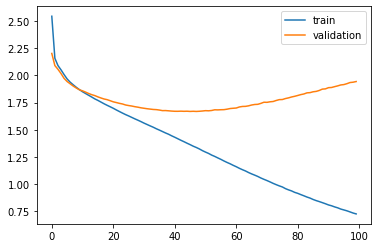

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

## Inferencing on the models

### 1) Defining inference models
We create inference models which help in predicting translations.

**Encoder inference model** : Takes the English sentence as input and outputs LSTM states ( `h` and `c` ).

**Decoder inference model** : Takes in 2 inputs, one are the LSTM states ( Output of encoder model ), second are the French input seqeunces ( ones not having the `<start>` tag ). It will output the translations of the English sentence which we fed to the encoder model and its state values.





In [23]:

def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 256,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 256 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model


### 2) Making some translations


1.   First, we take a English sequence and predict the state values using `enc_model`.
2.   We set the state values in the decoder's LSTM.
3.   Then, we generate a sequence which contains the `<start>` element.
4.   We input this sequence in the `dec_model`.
5.   We replace the `<start>` element with the element which was predicted by the `dec_model` and update the state values.
6.   We carry out the above steps iteratively till we hit the `<end>` tag or the maximum sequence length.







In [24]:

def str_to_tokens( sentence : str ):
    words = sentence.lower().split()
    tokens_list = list()
    for word in words:
          print("word ", word,eng_word_dict.get(word,1) )
          my_word=  eng_word_dict.get(word,1)
          tokens_list.append(my_word) 
  
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=max_input_length , padding='post')


In [31]:

enc_model , dec_model = make_inference_models()

#encoder_input_data.shape[0] 
for epoch in range(1 ):
    states_values = enc_model.predict( str_to_tokens("food was delicious" ) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = hindi_word_dict['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in hindi_word_dict.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > max_output_length:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    # print("Decoded Traslation ", decoded_translation )
    print(f"{bcolors.OKGREEN}Decoded Traslation: { decoded_translation}{bcolors.ENDC}")

    

word  food 299
word  was 10
word  delicious 1
Decoded Traslation:  में end


### Save Encoder and Decoder Parameters

In [35]:
model_path= '/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/model/'
# save encoder model
enc_model.save( model_path+'enc_model.h5' ) 
# save decoder model
dec_model.save( model_path+'dec_model.h5' ) 
# save  model
model.save( model_path+'model.h5' ) 

In [36]:
# encoder parameters
encoder_parameters={
    'max_encoder_seq_length': max_input_length,
    'num_encoder_tokens': num_eng_tokens,
   
}
encoder_dictionary= eng_word_dict

# decoder parameters
decoder_parameters={
    'max_decoder_seq_length':  max_output_length,
    'num_decoder_tokens': num_hindi_tokens,

}

decoder_dictionary=  hindi_word_dict



In [45]:
import pickle
paramters_path= model_path= '/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/'
dictionaries_path= model_path= '/content/drive/MyDrive/Machine Learning/NMT_Word_Level/My Version/'

# save encoder parameter
with open(paramters_path+'encoder_parameters.pickle', 'wb') as handle:
    pickle.dump(encoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder dictionary
with open(dictionaries_path+'encoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(encoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(paramters_path+'decoder_parameters.pickle', 'wb') as handle:
    pickle.dump(decoder_parameters, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save encoder parameter
with open(dictionaries_path+'decoder_dictionary.pickle', 'wb') as handle:
    pickle.dump(decoder_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)    



In [43]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored